# Learnable loss

## Setup

In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt

import torch

import higher

from ltl.determinism_helper import seed_generators
seed_generators(3)

from ltl.label_smoothing_loss import LabelSmoothingLoss
from ltl import utils

## Data

In [2]:
data_x = 0.0
data_y = -2.0
data_size = 0.3
data_width = 12.0
data_height = 6.0
data_counts = ([200,200,200],[75,75,75],[75,75,75])
#data_counts_acc = ([0],[0],[0])
#for i in range(len(data_counts)):
#    for j in range(len(data_counts[i])):
#        data_counts_acc[i].append(data_counts_acc[i][j]+data_counts[i][j])
data_functions = [
    lambda x: torch.cos(x), 
    lambda x: torch.full_like(x, 3.0)
]

def generateData(counts, noise=True):
    #Generate random points
    points = torch.rand((counts[0], 2), dtype=torch.float32)
    points[:,0] = data_x+points[:,0]*data_width
    points[:,1] = data_y+points[:,1]*data_height
    labels = torch.zeros((counts[0],), dtype=torch.long)

    #Remove random points from areas around functions
    for func in data_functions:
        points[:,1] += data_size*(torch.abs(points[:,1]-func(points[:,0]))<data_size)*torch.sign(points[:,1]-func(points[:,0]))

    #Generate points at function
    for i in range(len(data_functions)):
        tmp = data_x+torch.rand((counts[i+1],), dtype=torch.float32)*data_width
        points = torch.cat((points, torch.stack((tmp, data_functions[i](tmp)+(2.0*torch.rand((counts[i+1],))-1.0)*2.0/3.0*data_size), dim=1)))
        labels = torch.cat((labels, torch.full((counts[i+1],), i+1, dtype=torch.long)))

    if noise:
        for i in range(labels.shape[0]):
            labels[i] = utils._lgnt(torch.tensor([[0.80,0.1,0.1],[0.15,0.85,0.0],[0.15,0.0,0.85]]), labels[i])

    return points, labels

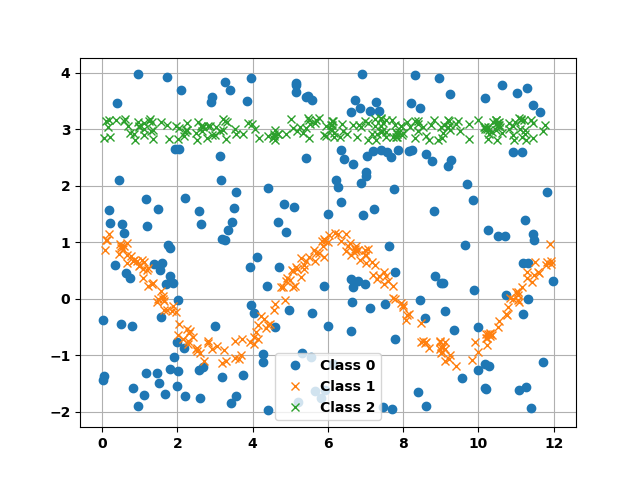

In [3]:
x_train, y_train = generateData(data_counts[0], False)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'o', label='Class 0')
axes.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'x', label='Class 1')
axes.plot(x_train[y_train==2,0], x_train[y_train==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()


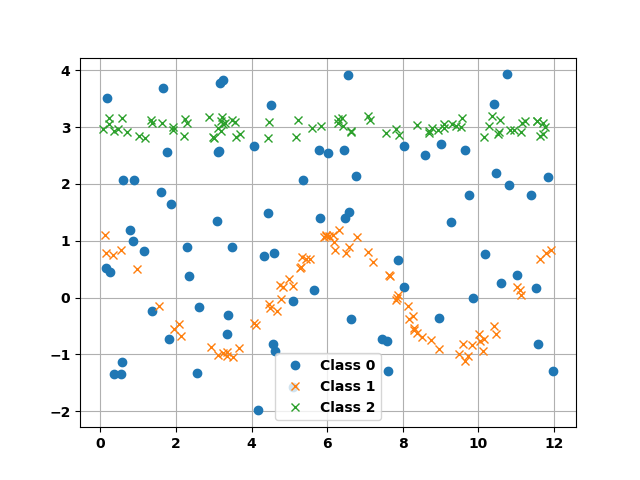

In [4]:
x_val, y_val = generateData(data_counts[1], False)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_val[y_val==0,0], x_val[y_val==0,1], 'o', label='Class 0')
axes.plot(x_val[y_val==1,0], x_val[y_val==1,1], 'x', label='Class 1')
axes.plot(x_val[y_val==2,0], x_val[y_val==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()

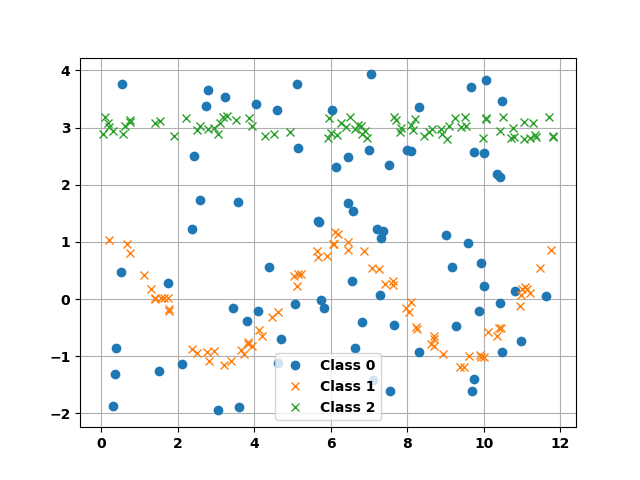

In [5]:
x_test, y_test = generateData(data_counts[2], False)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'o', label='Class 0')
axes.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'x', label='Class 1')
axes.plot(x_test[y_test==2,0], x_test[y_test==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()

## Model

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        count_hidden = 45
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, 3)
        )

    def forward(self, x):
        return self.layers(x)

## Standard

### Training

In [7]:
model = Net()
model.cuda()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 5000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/y_train.shape[0]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/y_test.shape[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Evaluation

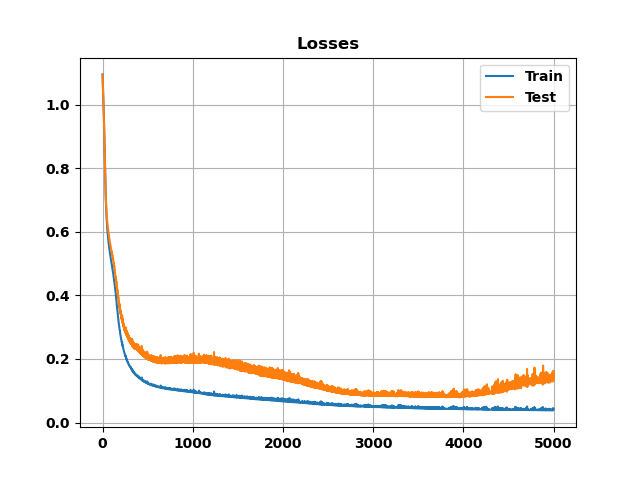

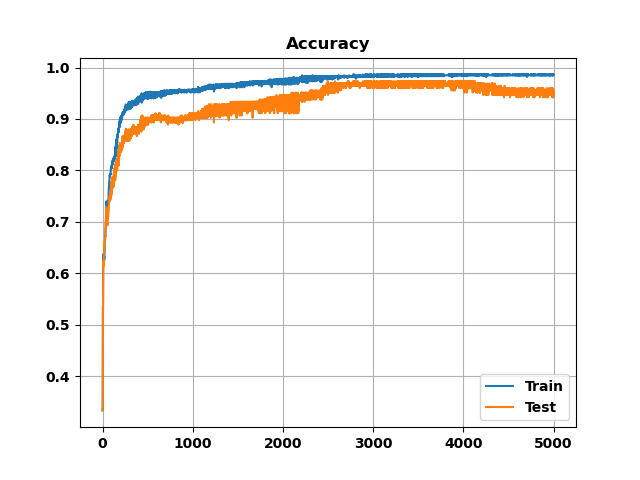

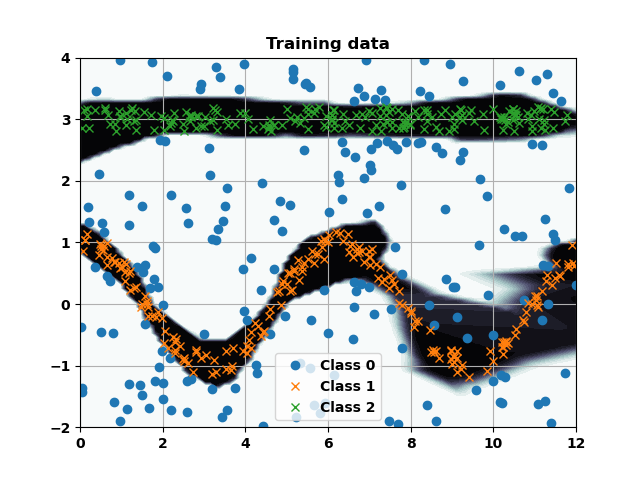

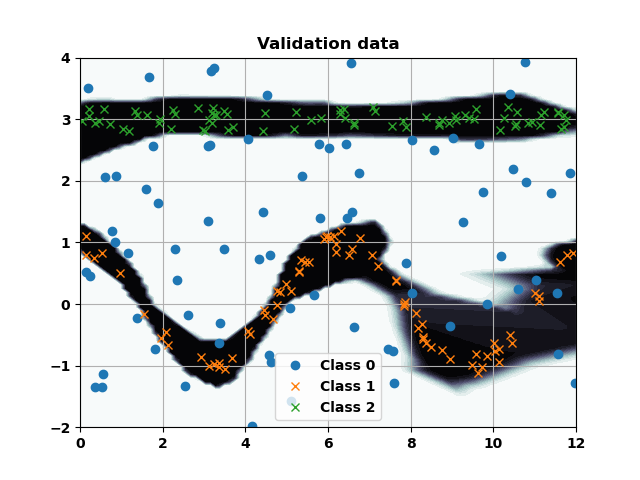

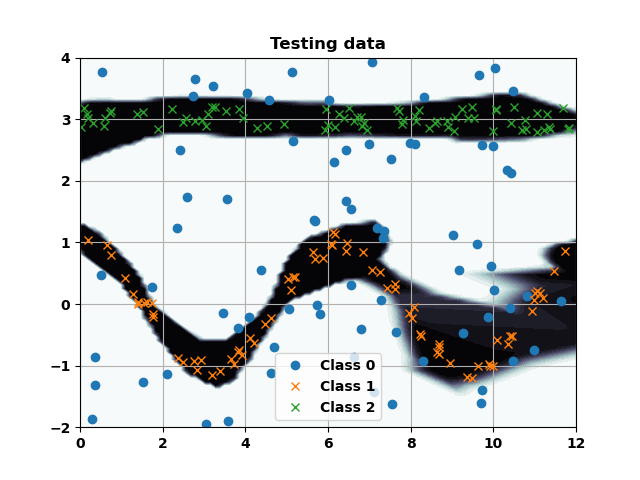

In [8]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Sweep

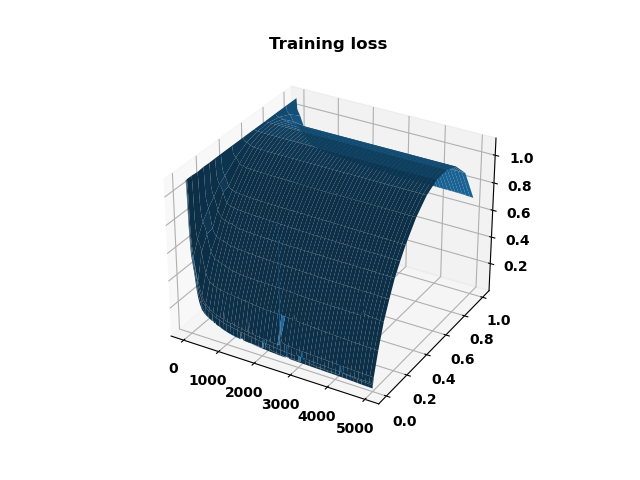

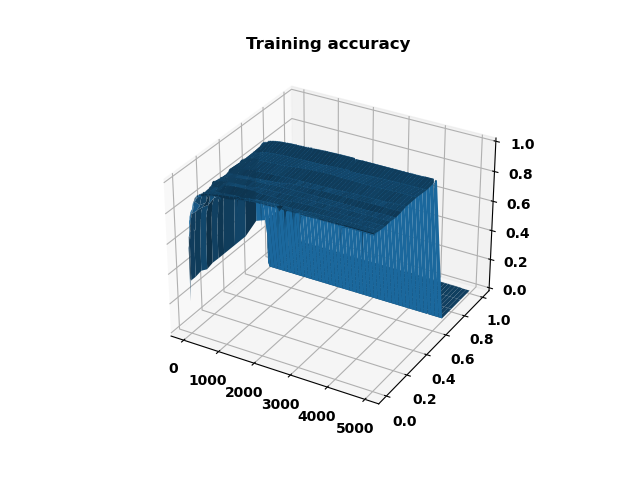

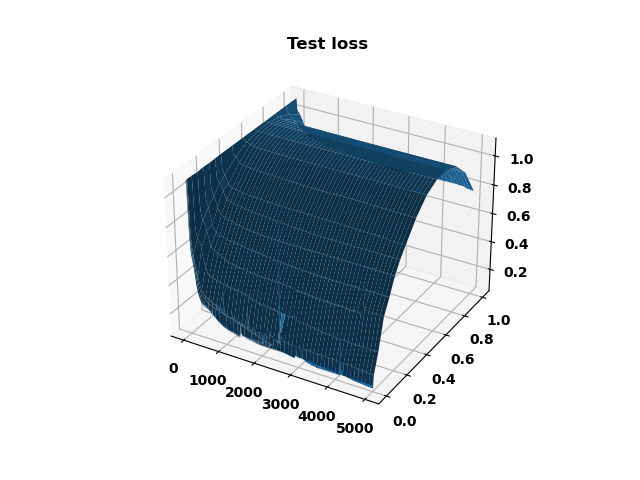

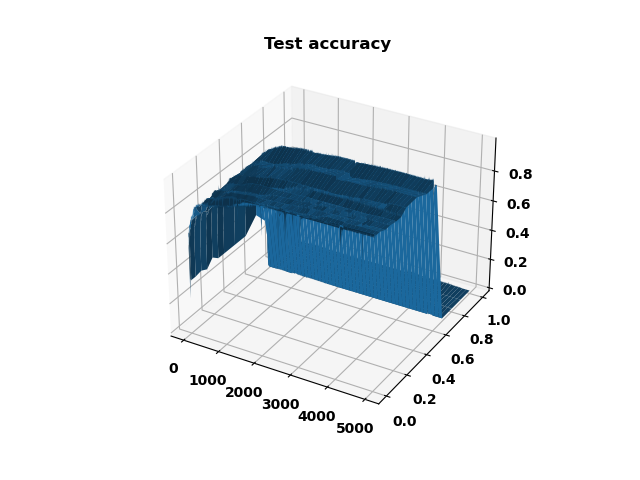

In [9]:
values = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epochs = 5000
losses_train = np.zeros((len(values),epochs))
accuracy_train = np.zeros((len(values),epochs))
losses_test = np.zeros((len(values),epochs))
accuracy_test = np.zeros((len(values),epochs))
    
for v in range(len(values)):
    model = Net()
    model.cuda()
    loss_function = LabelSmoothingLoss(3, torch.full((1,), values[v]), False)
    loss_function.cuda()
    optimizer = torch.optim.Adam(model.parameters())

    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_val   = x_val.cuda()
    y_val   = y_val.cuda()
    x_test  = x_test.cuda()
    y_test  = y_test.cuda()

    for i in range(epochs):
        z_train = model(x_train)
        loss = loss_function(z_train, y_train)
        losses_train[v,i] = loss.item()
        accuracy_train[v,i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/y_train.shape[0]
        losses_test[v,i] = loss_function(model(x_test), y_test).item()
        accuracy_test[v,i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/y_test.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Training loss")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, np.minimum(losses_train.transpose(1,0), 1.1))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Training accuracy")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, accuracy_train.transpose(1,0))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Test loss")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, np.minimum(losses_test.transpose(1,0), 1.1))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Test accuracy")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, accuracy_test.transpose(1,0))
axes.grid()

## Constant

### Training

In [10]:
model = Net()
model.cuda()
loss_function = LabelSmoothingLoss(3, torch.full((1,), 0.001), False)
loss_function.cuda()
optimizer = torch.optim.Adam(model.parameters())

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 5000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/y_train.shape[0]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/y_test.shape[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {loss_function(z_test, y_test)}")

### Evaluation

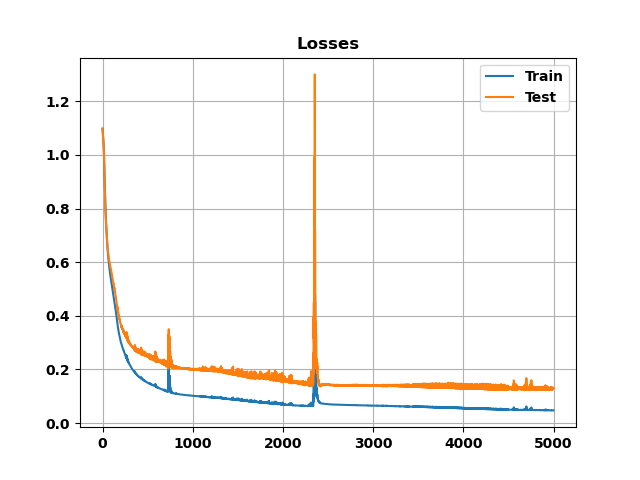

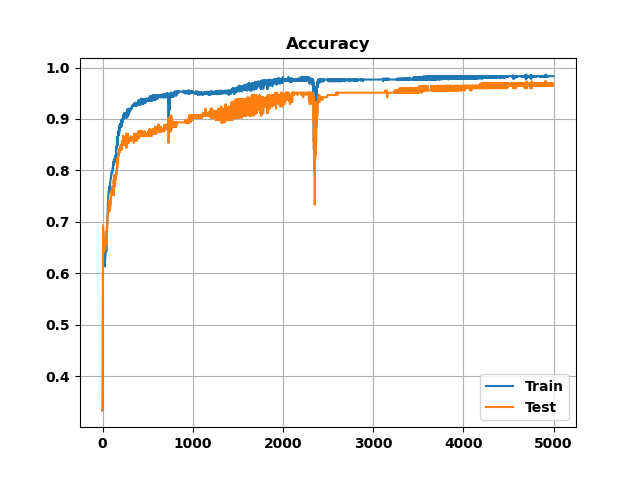

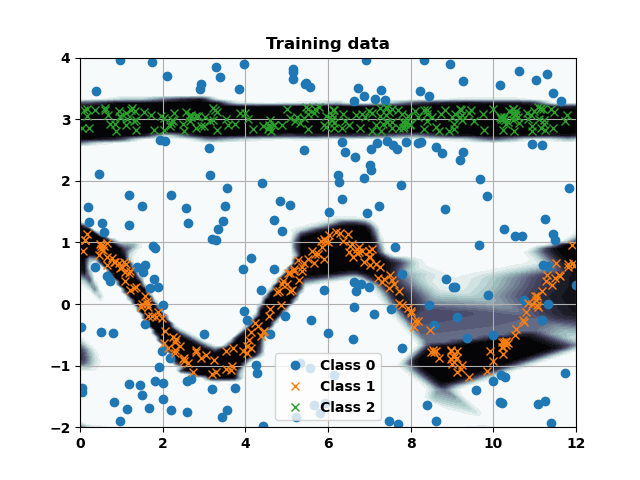

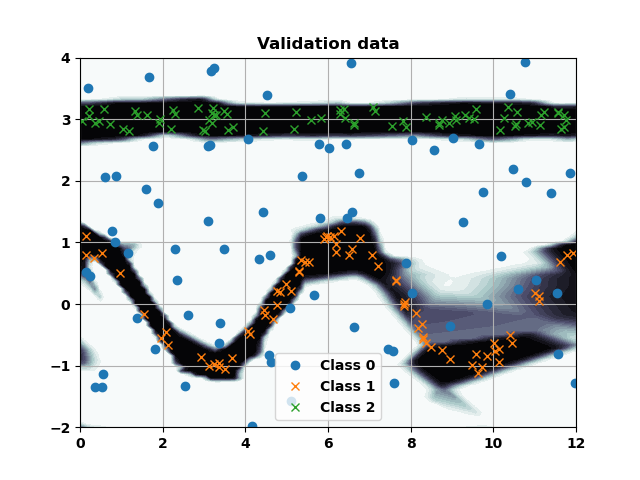

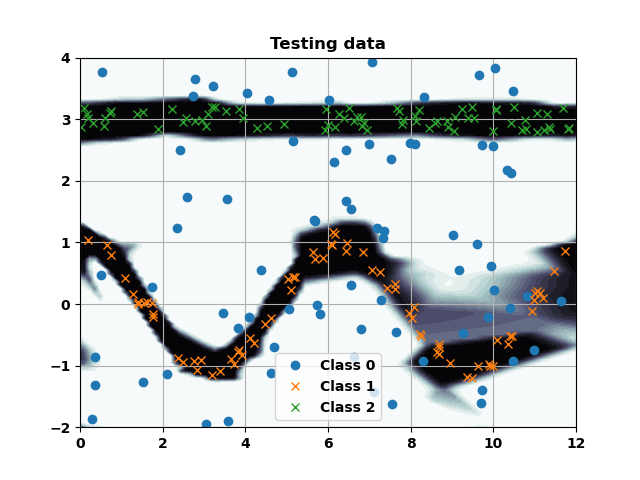

In [11]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Simultan

### Training

In [12]:
model = Net()
model.cuda()
loss_function = LabelSmoothingLoss(3, torch.full((1,), 0.0)) #Random
loss_function.cuda()
net_optimizer = torch.optim.Adam(model.parameters())
loss_optimizer = torch.optim.SGD(loss_function.parameters(), lr=1e-1)

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 5000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))
smoothings = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    print(f"Loss: {loss.item()}")
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/y_train.shape[0]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/y_test.shape[0]
    smoothings[i] = loss_function.smoothing.item()
    net_optimizer.zero_grad()
    loss_optimizer.zero_grad()
    loss.backward()
    net_optimizer.step()
    loss_optimizer.step()
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {loss_function(z_test, y_test)}")

Loss: 1.1022608280181885

Loss: 1.1005018949508667

Loss: 1.0993125438690186

Loss: 1.098459005355835

Loss: 1.097833514213562

Loss: 1.0973213911056519

Loss: 1.0968070030212402

Loss: 1.0962845087051392

Loss: 1.0957170724868774

Loss: 1.0951192378997803

Loss: 1.0944712162017822

Loss: 1.0937730073928833

Loss: 1.0930123329162598

Loss: 1.0921871662139893

Loss: 1.0913220643997192

Loss: 1.0904427766799927

Loss: 1.0895581245422363

Loss: 1.0886204242706299

Loss: 1.0876355171203613

Loss: 1.086623191833496

Loss: 1.0855799913406372

Loss: 1.084520936012268

Loss: 1.0834674835205078

Loss: 1.082419514656067

Loss: 1.0813826322555542

Loss: 1.080372929573059

Loss: 1.0794286727905273

Loss: 1.078543782234192

Loss: 1.0777058601379395

Loss: 1.0768944025039673

Loss: 1.0760927200317383

Loss: 1.0753140449523926

Loss: 1.0745078325271606

Loss: 1.0736708641052246

Loss: 1.0728038549423218

Loss: 1.071889877319336

Loss: 1.0709642171859741

Loss: 1.0700944662094116

Loss: 1.069262266159

Loss: 0.2171100378036499

Loss: 0.21646420657634735

Loss: 0.21578103303909302

Loss: 0.21498848497867584

Loss: 0.21423029899597168

Loss: 0.21352913975715637

Loss: 0.2127404510974884

Loss: 0.21204817295074463

Loss: 0.21136482059955597

Loss: 0.21076157689094543

Loss: 0.21006549894809723

Loss: 0.20947875082492828

Loss: 0.20859889686107635

Loss: 0.20770017802715302

Loss: 0.20685552060604095

Loss: 0.20609447360038757

Loss: 0.2052028924226761

Loss: 0.2044195532798767

Loss: 0.20370449125766754

Loss: 0.20301973819732666

Loss: 0.2023383229970932

Loss: 0.20159155130386353

Loss: 0.20102638006210327

Loss: 0.20034098625183105

Loss: 0.19959208369255066

Loss: 0.19891740381717682

Loss: 0.19826798141002655

Loss: 0.19769218564033508

Loss: 0.19722793996334076

Loss: 0.19718562066555023

Loss: 0.19764049351215363

Loss: 0.19828449189662933

Loss: 0.2007298320531845

Loss: 0.20002298057079315

Loss: 0.19863460958003998

Loss: 0.19365201890468597

Loss: 0.19275669753551483

Loss: 0


Loss: 0.11683596670627594

Loss: 0.11645350605249405

Loss: 0.11612054705619812

Loss: 0.1159631535410881

Loss: 0.11583162099123001

Loss: 0.11563899368047714

Loss: 0.11556234955787659

Loss: 0.11538121849298477

Loss: 0.11528950929641724

Loss: 0.11517491936683655

Loss: 0.11503710597753525

Loss: 0.11486373096704483

Loss: 0.11475878953933716

Loss: 0.1146141067147255

Loss: 0.11448434740304947

Loss: 0.11437083035707474

Loss: 0.11429057270288467

Loss: 0.11413674801588058

Loss: 0.1140076220035553

Loss: 0.11393949389457703

Loss: 0.11402156949043274

Loss: 0.11421602219343185

Loss: 0.11501331627368927

Loss: 0.11629857867956161

Loss: 0.1194847896695137

Loss: 0.11981933563947678

Loss: 0.12319202721118927

Loss: 0.11731714010238647

Loss: 0.11407717317342758

Loss: 0.1136460155248642

Loss: 0.11617676168680191

Loss: 0.12019772827625275

Loss: 0.11775597929954529

Loss: 0.11819000542163849

Loss: 0.11294317990541458

Loss: 0.11600644886493683

Loss: 0.11754998564720154

Loss:

Loss: 0.09317652136087418

Loss: 0.09479548037052155

Loss: 0.09343564510345459

Loss: 0.09128440916538239

Loss: 0.09360218048095703

Loss: 0.10218203812837601

Loss: 0.09528769552707672

Loss: 0.095927394926548

Loss: 0.09668592363595963

Loss: 0.10592532902956009

Loss: 0.10357902944087982

Loss: 0.0964876338839531

Loss: 0.14199791848659515

Loss: 0.19239845871925354

Loss: 0.25679007172584534

Loss: 0.13587775826454163

Loss: 0.24250738322734833

Loss: 0.11175567656755447

Loss: 0.14952687919139862

Loss: 0.18642950057983398

Loss: 0.11149879544973373

Loss: 0.10848651081323624

Loss: 0.15081271529197693

Loss: 0.10958948731422424

Loss: 0.13902664184570312

Loss: 0.12504331767559052

Loss: 0.10762201994657516

Loss: 0.11167389154434204

Loss: 0.11220568418502808

Loss: 0.11094233393669128

Loss: 0.09422314912080765

Loss: 0.11915028840303421

Loss: 0.10470456629991531

Loss: 0.1004188060760498

Loss: 0.10222876816987991

Loss: 0.09269798547029495

Loss: 0.09665670245885849

Loss:


Loss: 0.06688906252384186

Loss: 0.0673995092511177

Loss: 0.06961709260940552

Loss: 0.06820923089981079

Loss: 0.06857635825872421

Loss: 0.06649583578109741

Loss: 0.06559180468320847

Loss: 0.06476369500160217

Loss: 0.06459512561559677

Loss: 0.06506865471601486

Loss: 0.06587251275777817

Loss: 0.06766128540039062

Loss: 0.06720517575740814

Loss: 0.06840826570987701

Loss: 0.06673892587423325

Loss: 0.0663653165102005

Loss: 0.06505922973155975

Loss: 0.06424984335899353

Loss: 0.06431937962770462

Loss: 0.06448405236005783

Loss: 0.06513898074626923

Loss: 0.06499088555574417

Loss: 0.06531967222690582

Loss: 0.06473445147275925

Loss: 0.0647931918501854

Loss: 0.06427974253892899

Loss: 0.06415660679340363

Loss: 0.06383954733610153

Loss: 0.06371424347162247

Loss: 0.06345794349908829

Loss: 0.06345458328723907

Loss: 0.06351176649332047

Loss: 0.06365615874528885

Loss: 0.06409884989261627

Loss: 0.06425375491380692

Loss: 0.06518730521202087

Loss: 0.0652661919593811

Loss

Loss: 0.05326002091169357

Loss: 0.051511410623788834

Loss: 0.05174579471349716

Loss: 0.051301367580890656

Loss: 0.05086627975106239

Loss: 0.05126065015792847

Loss: 0.05087846517562866

Loss: 0.05196210741996765

Loss: 0.05271553620696068

Loss: 0.05359642207622528

Loss: 0.05388558655977249

Loss: 0.05239255726337433

Loss: 0.051259588450193405

Loss: 0.050813980400562286

Loss: 0.05034797638654709

Loss: 0.05085381120443344

Loss: 0.05107051506638527

Loss: 0.051897209137678146

Loss: 0.05169476568698883

Loss: 0.05091658607125282

Loss: 0.05124889314174652

Loss: 0.0502471886575222

Loss: 0.05116057023406029

Loss: 0.050500884652137756

Loss: 0.05134625360369682

Loss: 0.051495857536792755

Loss: 0.05166417360305786

Loss: 0.051195546984672546

Loss: 0.050484828650951385

Loss: 0.049981918185949326

Loss: 0.04979611560702324

Loss: 0.049622900784015656

Loss: 0.049656134098768234

Loss: 0.04973377287387848

Loss: 0.049898695200681686

Loss: 0.05014282837510109

Loss: 0.05038294

Loss: 0.08282005041837692

Loss: 0.07498536258935928

Loss: 0.06139293313026428

Loss: 0.05123300850391388

Loss: 0.07890145480632782

Loss: 0.18407373130321503

Loss: 0.07729325443506241

Loss: 0.22989265620708466

Loss: 0.2625713646411896

Loss: 0.3644445240497589

Loss: 0.1600896567106247

Loss: 0.3978385031223297

Loss: 0.1667555868625641

Loss: 0.4538969397544861

Loss: 0.30600982904434204

Loss: 0.1916903406381607

Loss: 0.1671167016029358

Loss: 0.16680805385112762

Loss: 0.22449880838394165

Loss: 0.2248331755399704

Loss: 0.16651871800422668

Loss: 0.14300154149532318

Loss: 0.10848556458950043

Loss: 0.14587754011154175

Loss: 0.14881829917430878

Loss: 0.14927785098552704

Loss: 0.10968165099620819

Loss: 0.0698525458574295

Loss: 0.08533953875303268

Loss: 0.11396906524896622

Loss: 0.09317640960216522

Loss: 0.08715122193098068

Loss: 0.09114507585763931

Loss: 0.08157903701066971

Loss: 0.06533709168434143

Loss: 0.06969866901636124

Loss: 0.07919467240571976

Loss: 0.068

Loss: 0.04146408289670944

Loss: 0.04144195094704628

Loss: 0.041416943073272705

Loss: 0.04139350354671478

Loss: 0.04136938974261284

Loss: 0.04136411473155022

Loss: 0.04133929684758186

Loss: 0.041313428431749344

Loss: 0.04129800945520401

Loss: 0.04128415510058403

Loss: 0.0412670336663723

Loss: 0.04124454781413078

Loss: 0.04122282564640045

Loss: 0.041199490427970886

Loss: 0.04117629677057266

Loss: 0.041157208383083344

Loss: 0.041134197264909744

Loss: 0.04111500084400177

Loss: 0.0410957932472229

Loss: 0.04107382148504257

Loss: 0.04106388986110687

Loss: 0.041036732494831085

Loss: 0.04102247208356857

Loss: 0.04100222513079643

Loss: 0.04098259657621384

Loss: 0.04096117615699768

Loss: 0.04094225913286209

Loss: 0.04092218354344368

Loss: 0.04090898111462593

Loss: 0.04088618606328964

Loss: 0.04087192937731743

Loss: 0.040844351053237915

Loss: 0.040825363248586655

Loss: 0.0408066064119339

Loss: 0.040792860090732574

Loss: 0.04077090695500374

Loss: 0.04074852168560

Loss: 0.034813977777957916

Loss: 0.03479865938425064

Loss: 0.034780025482177734

Loss: 0.03477109968662262

Loss: 0.0347323939204216

Loss: 0.03472158685326576

Loss: 0.03469022735953331

Loss: 0.03469684720039368

Loss: 0.034652404487133026

Loss: 0.03463652357459068

Loss: 0.03461436554789543

Loss: 0.03460333123803139

Loss: 0.034570351243019104

Loss: 0.03455501049757004

Loss: 0.03452891856431961

Loss: 0.034514136612415314

Loss: 0.034496258944272995

Loss: 0.03447596728801727

Loss: 0.034454088658094406

Loss: 0.034431882202625275

Loss: 0.034409042447805405

Loss: 0.034393180161714554

Loss: 0.034370455890893936

Loss: 0.03435142710804939

Loss: 0.034333936870098114

Loss: 0.03431466966867447

Loss: 0.03429466485977173

Loss: 0.03427061066031456

Loss: 0.03426937013864517

Loss: 0.034238919615745544

Loss: 0.03422144055366516

Loss: 0.03420712798833847

Loss: 0.0341791994869709

Loss: 0.034165430814027786

Loss: 0.03414721414446831

Loss: 0.03411664441227913

Loss: 0.03411298

Loss: 0.02907227911055088

Loss: 0.02906760200858116

Loss: 0.029019732028245926

Loss: 0.02905202843248844

Loss: 0.028990669175982475

Loss: 0.02900078520178795

Loss: 0.028972575441002846

Loss: 0.028960060328245163

Loss: 0.028928661718964577

Loss: 0.02891094982624054

Loss: 0.02889113500714302

Loss: 0.028890591114759445

Loss: 0.02885909378528595

Loss: 0.02884351834654808

Loss: 0.02882929891347885

Loss: 0.02881237491965294

Loss: 0.028800301253795624

Loss: 0.028781656175851822

Loss: 0.028761452063918114

Loss: 0.028746994212269783

Loss: 0.028726540505886078

Loss: 0.02872217819094658

Loss: 0.028696784749627113

Loss: 0.028682414442300797

Loss: 0.028668556362390518

Loss: 0.028649915009737015

Loss: 0.02863609790802002

Loss: 0.028620250523090363

Loss: 0.028601977974176407

Loss: 0.028590256348252296

Loss: 0.02856888435781002

Loss: 0.028576990589499474

Loss: 0.028538065031170845

Loss: 0.028550298884510994

Loss: 0.0285038985311985

Loss: 0.028512662276625633

Loss: 0

Loss: 0.024524448439478874

Loss: 0.024523774161934853

Loss: 0.024516534060239792

Loss: 0.02448493428528309

Loss: 0.024514738470315933

Loss: 0.02447069250047207

Loss: 0.02447453886270523

Loss: 0.024434616789221764

Loss: 0.02446138858795166

Loss: 0.024412978440523148

Loss: 0.02440376579761505

Loss: 0.024379177019000053

Loss: 0.024357663467526436

Loss: 0.024347996339201927

Loss: 0.02435210347175598

Loss: 0.024364545941352844

Loss: 0.024391133338212967

Loss: 0.024314207956194878

Loss: 0.0243284460157156

Loss: 0.02426701970398426

Loss: 0.024320947006344795

Loss: 0.024306220933794975

Loss: 0.0243646502494812

Loss: 0.02427787333726883

Loss: 0.024254387244582176

Loss: 0.024189893156290054

Loss: 0.024205291643738747

Loss: 0.024223826825618744

Loss: 0.024175377562642097

Loss: 0.024193035438656807

Loss: 0.024123912677168846

Loss: 0.02412918396294117

Loss: 0.024080025032162666

Loss: 0.0241216029971838

Loss: 0.02408323436975479

Loss: 0.024056551977992058

Loss: 0.

Loss: 0.046424493193626404

Loss: 0.046402301639318466

Loss: 0.04637549817562103

Loss: 0.04634618014097214

Loss: 0.04632139578461647

Loss: 0.04629703238606453

Loss: 0.046271901577711105

Loss: 0.04625150188803673

Loss: 0.04622887447476387

Loss: 0.046202532947063446

Loss: 0.04618298262357712

Loss: 0.04616100341081619

Loss: 0.0461413599550724

Loss: 0.04612065851688385

Loss: 0.04609747231006622

Loss: 0.04607892408967018

Loss: 0.046056099236011505

Loss: 0.04603716731071472

Loss: 0.0460168719291687

Loss: 0.04599357768893242

Loss: 0.045967645943164825

Loss: 0.0459371842443943

Loss: 0.045918453484773636

Loss: 0.04589468240737915

Loss: 0.04586333408951759

Loss: 0.04584600403904915

Loss: 0.045826129615306854

Loss: 0.04580480232834816

Loss: 0.0457814559340477

Loss: 0.045757804065942764

Loss: 0.045732684433460236

Loss: 0.04570971801877022

Loss: 0.04569146782159805

Loss: 0.04566562920808792

Loss: 0.04564811289310455

Loss: 0.04562757536768913

Loss: 0.04560761898756

Loss: 0.04235352203249931

Loss: 0.0423579104244709

Loss: 0.042340971529483795

Loss: 0.04233808442950249

Loss: 0.04232906922698021

Loss: 0.04231236129999161

Loss: 0.042309775948524475

Loss: 0.04229721054434776

Loss: 0.04229011386632919

Loss: 0.042293570935726166

Loss: 0.042276255786418915

Loss: 0.04227707162499428

Loss: 0.04226646572351456

Loss: 0.04225675016641617

Loss: 0.04224420711398125

Loss: 0.042238831520080566

Loss: 0.04224041849374771

Loss: 0.0422380156815052

Loss: 0.04222209379076958

Loss: 0.04221392422914505

Loss: 0.0422111451625824

Loss: 0.04220212623476982

Loss: 0.04219726100564003

Loss: 0.04219230264425278

Loss: 0.04218055680394173

Loss: 0.042174290865659714

Loss: 0.04215915873646736

Loss: 0.0421503521502018

Loss: 0.04214872419834137

Loss: 0.04213425889611244

Loss: 0.04212808609008789

Loss: 0.04211956262588501

Loss: 0.04211371764540672

Loss: 0.0421147458255291

Loss: 0.04210202023386955

Loss: 0.04209281504154205

Loss: 0.04208597168326378



Loss: 0.04012244939804077

Loss: 0.04011194780468941

Loss: 0.04010475426912308

Loss: 0.040099166333675385

Loss: 0.040100157260894775

Loss: 0.04008561372756958

Loss: 0.040081825107336044

Loss: 0.04007573053240776

Loss: 0.040071506053209305

Loss: 0.0400620698928833

Loss: 0.04006008431315422

Loss: 0.04005227982997894

Loss: 0.04004795849323273

Loss: 0.04004017636179924

Loss: 0.04002681374549866

Loss: 0.04003192484378815

Loss: 0.040009379386901855

Loss: 0.04001374542713165

Loss: 0.04000554978847504

Loss: 0.040005333721637726

Loss: 0.03999059274792671

Loss: 0.03999603912234306

Loss: 0.0399773083627224

Loss: 0.03996938839554787

Loss: 0.0399618074297905

Loss: 0.03995615243911743

Loss: 0.0399533212184906

Loss: 0.03993738442659378

Loss: 0.039944447576999664

Loss: 0.0399264395236969

Loss: 0.0399283766746521

Loss: 0.039917171001434326

Loss: 0.03990688547492027

Loss: 0.03990129008889198

Loss: 0.03989225998520851

Loss: 0.03988703712821007

Loss: 0.039884764701128006

Loss: 0.0381692573428154

Loss: 0.0381753146648407

Loss: 0.03815107420086861

Loss: 0.03816122189164162

Loss: 0.038150619715452194

Loss: 0.03814718872308731

Loss: 0.03814950957894325

Loss: 0.03812798112630844

Loss: 0.03812038525938988

Loss: 0.038116298615932465

Loss: 0.03810267895460129

Loss: 0.03809471055865288

Loss: 0.0381106436252594

Loss: 0.03808875009417534

Loss: 0.03808272257447243

Loss: 0.03808584809303284

Loss: 0.03806408494710922

Loss: 0.03808895871043205

Loss: 0.03807121887803078

Loss: 0.038058046251535416

Loss: 0.0380668006837368

Loss: 0.0380411222577095

Loss: 0.038050442934036255

Loss: 0.03805887699127197

Loss: 0.03801540285348892

Loss: 0.03802669048309326

Loss: 0.038041457533836365

Loss: 0.03799830377101898

Loss: 0.038011204451322556

Loss: 0.038005173206329346

Loss: 0.03798013925552368

Loss: 0.037984613329172134

Loss: 0.037989292293787

Loss: 0.0379728339612484

Loss: 0.03796824812889099

Loss: 0.037959158420562744

Loss: 0.03797169402241707



Loss: 0.03624816983938217

Loss: 0.03623875230550766

Loss: 0.03624226525425911

Loss: 0.036224447190761566

Loss: 0.03620004281401634

Loss: 0.03619161620736122

Loss: 0.0361921489238739

Loss: 0.036193542182445526

Loss: 0.03618656098842621

Loss: 0.0361841656267643

Loss: 0.03620181977748871

Loss: 0.036173272877931595

Loss: 0.03614895045757294

Loss: 0.036149729043245316

Loss: 0.03615068644285202

Loss: 0.03614465147256851

Loss: 0.03612487390637398

Loss: 0.036123838275671005

Loss: 0.03615933284163475

Loss: 0.036137841641902924

Loss: 0.0361008383333683

Loss: 0.03611670434474945

Loss: 0.03613557294011116

Loss: 0.03608401119709015

Loss: 0.0360899418592453

Loss: 0.03611861169338226

Loss: 0.0360671691596508

Loss: 0.036080632358789444

Loss: 0.03607269376516342

Loss: 0.036069758236408234

Loss: 0.0360671766102314

Loss: 0.036047808825969696

Loss: 0.03604602441191673

Loss: 0.03603605553507805

Loss: 0.03601072356104851

Loss: 0.036047644913196564

Loss: 0.0360262133181095

Loss: 0.03422025591135025

Loss: 0.03428761661052704

Loss: 0.034286148846149445

Loss: 0.03422131389379501

Loss: 0.0341426283121109

Loss: 0.03412048518657684

Loss: 0.034116461873054504

Loss: 0.03412787243723869

Test loss: 0.12534154951572418


### Evaluation

C:\Users\alexa\AppData\Local\Temp/ipykernel_7660/248309543.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


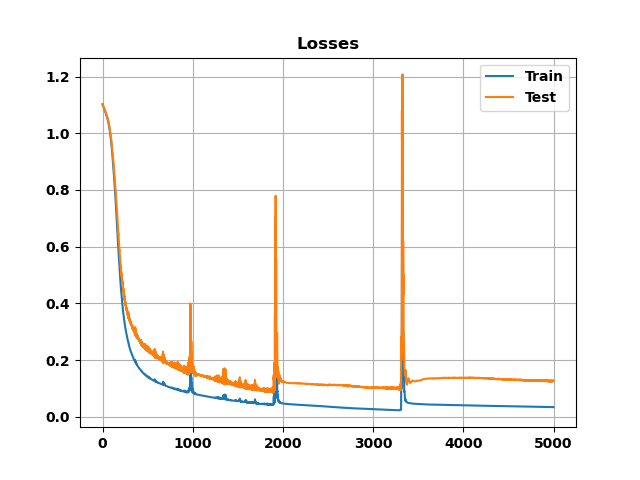

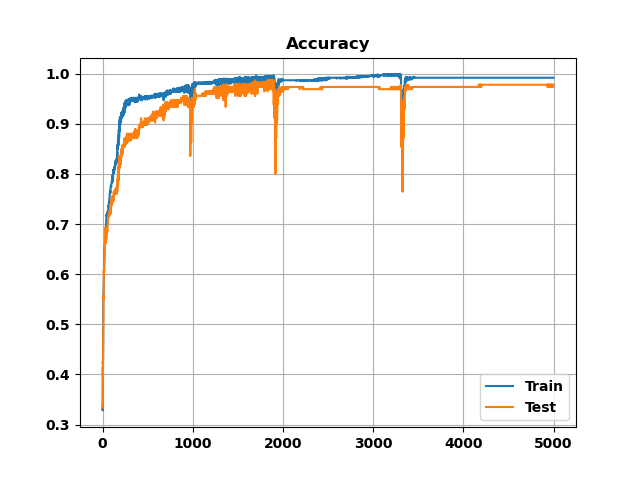

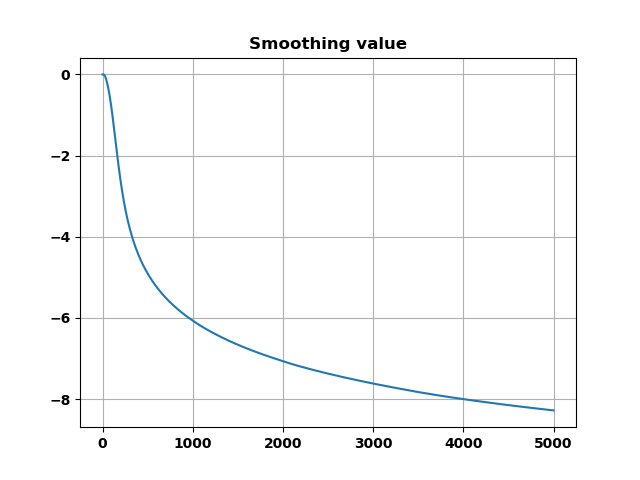

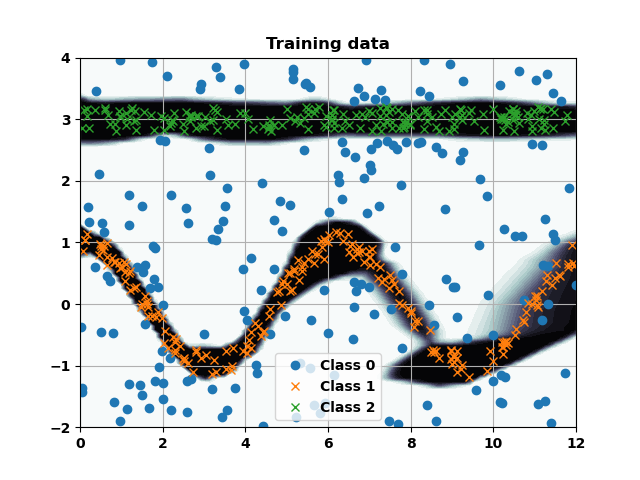

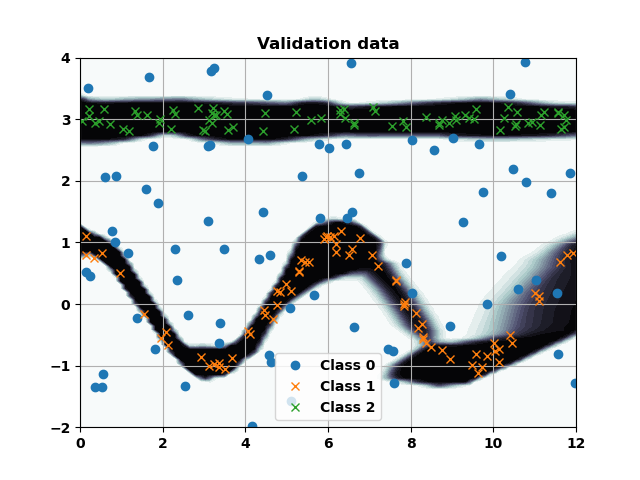

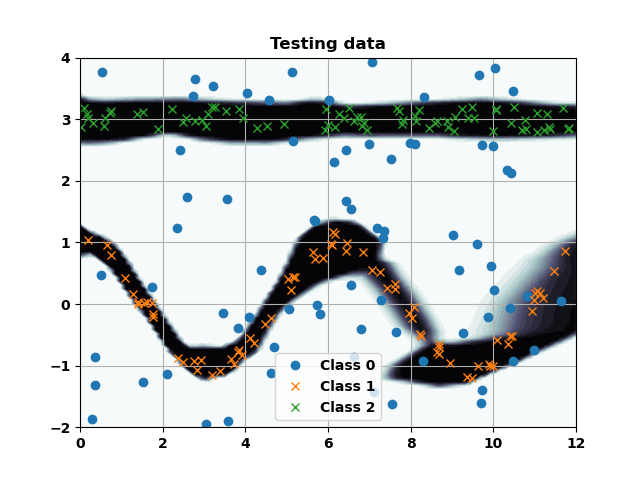

In [13]:
model.eval()
model.cuda()


fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Smoothing value")
axes.plot(np.arange(smoothings.shape[0]), smoothings)
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Bilevel

### Training

In [ ]:
model = Net()
model.cuda()
#inner_loss_function = LabelSmoothingLoss(3, torch.full((1,),0.0))#torch.diag(torch.ones((3,))))
inner_loss_function = LabelSmoothingLoss(3, torch.diag(torch.ones((3,))), False)
inner_loss_function.cuda()
outer_loss_function = torch.nn.CrossEntropyLoss()
inner_optimizer = torch.optim.Adam(model.parameters())
outer_optimizer = torch.optim.SGD(inner_loss_function.parameters(), lr=1e-1)

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

#############
inner_optimizer.zero_grad()
inner_loss_function(model(x_train[0].unsqueeze(0)), y_train[0].unsqueeze(0)).backward()
inner_optimizer.step()
#############

epochs = 1000
inner_iterations = 5
inner_losses_train   = np.zeros((epochs,))
outer_losses_val   = np.zeros((epochs,))
losses_test   = np.zeros((epochs,))
inner_accuracy_train = np.zeros((epochs,))
outer_accuracy_val = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))
smoothings     = np.zeros((epochs,))

for i in range(epochs):
    with higher.innerloop_ctx(model, inner_optimizer) as (fmodel, diffopt):
        loss_acc = 0
        acc_acc = 0
        for j in range(inner_iterations):
            z_train = fmodel(x_train)
            inner_loss = inner_loss_function(z_train, y_train)
            loss_acc += inner_loss.item()
            acc_acc += (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/y_train.shape[0]
            diffopt.step(inner_loss)
        new_model_state = fmodel.state_dict()
        new_optimizer_state = diffopt.state[0]
        inner_losses_train[i] = loss_acc/inner_iterations
        inner_accuracy_train[i] = acc_acc/inner_iterations
            
        z_val = fmodel(x_val)
        outer_loss = outer_loss_function(z_val, y_val)
        outer_accuracy_val[i] = (torch.argmax(torch.nn.functional.softmax(z_val, dim=1), dim=1)==y_val).sum()/y_val.shape[0]
        outer_losses_val[i] = outer_loss.item()
        outer_optimizer.zero_grad()
        outer_loss.backward()
        outer_optimizer.step()
        #smoothings[i] = inner_loss_function.smoothing.item()

    losses_test[i] = outer_loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/y_test.shape[0]

    utils.copy_higher_to_torch(new_model_state, new_optimizer_state, model, inner_optimizer)

### Evaluation

In [ ]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(inner_losses_train.shape[0]), inner_losses_train, label="Inner train")
axes.plot(np.arange(outer_losses_val.shape[0]), outer_losses_val, label="Outer train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(inner_accuracy_train.shape[0]), inner_accuracy_train, label="Inner train")
axes.plot(np.arange(outer_accuracy_val.shape[0]), outer_accuracy_val, label="Outer train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Smoothing value")
axes.plot(np.arange(smoothings.shape[0]), smoothings)
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

    utils.render_matrix(utils.translate_to_zero(inner_loss_function.smoothing.clone().detach().cpu().numpy()), "Smoothing matrix", "Correct label", "Weight")